In [1]:
import torch
import random
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import huffman
import math
import faiss
import sys
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
import warnings
warnings.filterwarnings('ignore')

# ImageNet Experiments: Size reduction  through Huffman coding

In [2]:
def plot_pdf_distribution(pdf):
    print(len(pdf))
    plt.rcParams['figure.figsize'] = [4,3]
    plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
    plt.rcParams.update({'font.size': 10})
    # plt.ticklabel_format(axis='x', style="sci", scilimits=(0,0), useOffset=False)
    # plt.hist(imagenet_pdf2048, bins=25, alpha=0.75, rwidth=0.75)
    # plt.gca().set(ylabel='# of centroids in that bin', xlabel='# of centroids in a bin is hit', xscale='log', autoscale_on=True);
    plt.ticklabel_format(style='plain')
    plt.hist(pdf, bins=25, alpha=0.75, rwidth=0.75) #, log=True)
    plt.gca().set(ylabel='# of centroids in that bin', xlabel='# of times centroids in a bin is hit');

In [13]:
def plot_data_savings(pdf,n_clusters):
    # create the dictionary
    freq_dict = []
    for i in range(n_clusters):
        freq_dict.append((i, pdf[i]))
    code_book = huffman.codebook(freq_dict)   

    code_book_dist = np.zeros((n_clusters,),dtype=np.int)
    for j in range(n_clusters):
        code_book_dist[j]=len(code_book[j])

    plt.rcParams['figure.figsize'] = [3,3]
    plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
    plt.rcParams.update({'font.size': 10})
    plt.ticklabel_format(style='plain')
    plt.hist(code_book_dist, bins=6, alpha=0.75, rwidth=0.75)
    plt.gca().set(ylabel='# of symbols in that bin', xlabel='bins of bits per symbol');    

    base_bits = (math.log10(n_clusters) / math.log10(2))
    print(base_bits)

    # with no encoding, 11 bits needed to encode 2048 symbols, 9 for 512
    total_non_encoded = 0
    for i in range(n_clusters):
        total_non_encoded += pdf[i]*base_bits

    total_encoded = 0
    for i in range(n_clusters):
        total_encoded += pdf[i]*code_book_dist[i]
    return 100*(1 - total_encoded/total_non_encoded)

2048


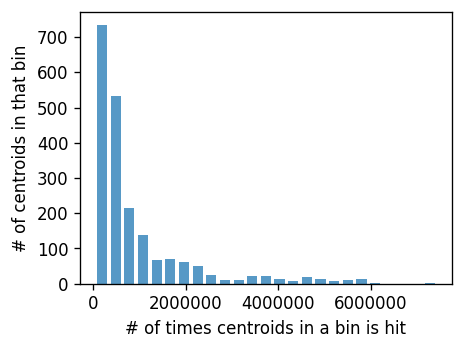

In [4]:
imagenet_pdf2048 = np.genfromtxt('./imagenet_pdf2048.txt', delimiter=',')
plot_pdf_distribution(imagenet_pdf2048)

11.0
Savings in storage for Imagenet (50k) testset: 6.65%


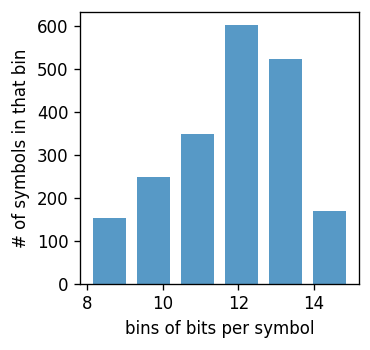

In [5]:
savings = plot_data_savings(imagenet_pdf2048,2048)
print("Savings in storage for Imagenet (50k) testset: {:.2f}%".format(savings))    

512


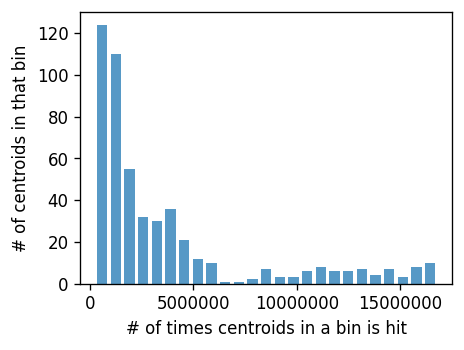

In [5]:
imagenet_pdf512 = np.genfromtxt('./imagenet_pdf512.txt', delimiter=',')
plot_pdf_distribution(imagenet_pdf512)

In [9]:
imagenet_codedist512 = np.genfromtxt('./imagenet_codebook_dist512.txt', delimiter=',')

9.0
Savings in storage for Imagenet (50k) testset: 7.99%


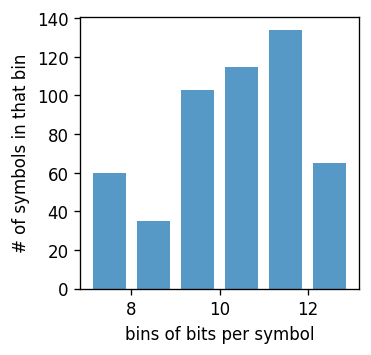

In [14]:
savings = plot_data_savings(imagenet_pdf512,512)
print("Savings in storage for Imagenet (50k) testset: {:.2f}%".format(savings))    

In [15]:
total_non_encoded = 0 
for i in range(512):
    total_non_encoded += imagenet_pdf512[i]*9

total_encoded = 0 
for i in range(512):
    total_encoded += imagenet_pdf512[i]*imagenet_codedist512[i]
    
print("Non encoded:", total_non_encoded)    
print("Encoded:", total_encoded)    
print(np.mean(imagenet_codedist512))
print("Savings in storage for imagent testset: {:.2f}%".format(100*(1 - total_encoded/total_non_encoded))) 

Non encoded: 16934400000.0
Encoded: 15581088645.0
9.830078125
Savings in storage for imagent testset: 7.99%


In [16]:
import PIL

print('Pillow Version:', PIL.__version__)

Pillow Version: 8.3.2


In [17]:
# load and show an image with Pillow

from PIL import Image

# Open the image form working directory

image = Image.open('./n13054560_bolete.JPEG')

# summarize some details about the image

print(image.format)

print(image.size)

print(image.mode)



JPEG
(500, 377)
RGB


NameError: name 'load_image' is not defined

In [18]:
from numpy import asarray

# load the image

image = Image.open('./n13054560_bolete.JPEG')

# convert image to numpy array

data = asarray(image)

print(type(data))

# summarize shape

print(data.shape)


# create Pillow image

image2 = Image.fromarray(data)

print(type(image2))


# summarize image details

print(image2.mode)

print(image2.size)

<class 'numpy.ndarray'>
(377, 500, 3)
<class 'PIL.Image.Image'>
RGB
(500, 377)


In [24]:
print(data[:,:,1])

[[11 49 49 ...  0  2 33]
 [ 6 36 39 ...  5  0  8]
 [11 25 28 ... 13  5  0]
 ...
 [12 11 11 ... 10 14 73]
 [13 12 17 ... 43 24 29]
 [10 11 11 ... 64 30 32]]


In [25]:
print("Size of the array: ",
      data.size)
  
print("Memory size of one array element in bytes: ",
      data.itemsize)
  
# memory size of numpy array in bytes
print("Memory size of numpy array in bytes:",
      data.size * data.itemsize)

Size of the array:  565500
Memory size of one array element in bytes:  1
Memory size of numpy array in bytes: 565500


In [26]:
from torchvision.utils import save_image



In [27]:
from  patchutils_img_imagenet import fm_to_symbolic_fm,fm_to_multisym_fm
import faiss 
    
index = faiss.read_index("./kmeans_img_imgnet_k2_s0_c2048_v0.index")
n_clusters=2048
patch_size = (2, 2)
channel_count = 3 
repeat = 2 
location=False

stride = 0
centroid_lut = index.reconstruct_n(0, n_clusters)

def data_to_symbol(perturbed_data, index):
    #pfm = perturbed_data.data.cpu().numpy().copy()
    # Re-classify the perturbed image
    pfm = perturbed_data
    Xsym_ = fm_to_symbolic_fm(pfm.squeeze(), n_clusters, index, centroid_lut, patch_size, stride, channel_count)
    Xsym = torch.from_numpy(Xsym_)
    Xsym = Xsym.unsqueeze(0)
    return Xsym.float()

def clean_accuracy_symbolic(index, model: nn.Module,
                   x: torch.Tensor,
                   y: torch.Tensor,
                   batch_size: int = 1):
    acc = 0.
    n_batches = math.ceil(x.shape[0] / batch_size)
    with torch.no_grad():
        for counter in range(n_batches):
            x_curr = x[counter * batch_size:(counter + 1) *
                       batch_size]
            y_curr = y[counter * batch_size:(counter + 1) *
                       batch_size]



            output = model(data_to_symbol(x_curr, index))
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            if final_pred.item() == y_curr.item():
                acc += 1

    return acc / x.shape[0]